In [1]:
from llm.context.llm_context import LLMContext
from llm.strategy.big_llama_model import BigLlamaModel
from llm.strategy.big_llama3_1_model import BigLlama3_1Model
from llm.strategy.small_llama_model import SmallLlamaModel
from llm.strategy.big_mistral_model import BigMistralModel
from llm.strategy.haiku3_model import Haiku3Model
from llm.strategy.sonet3_model import Sonet3Model
from llm.strategy.opus3_model import OpusModel
from llm.strategy.sonet3_5_model import Sonet3_5Model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
from tqdm import tqdm
import os
import numpy as np 
import pandas as pd
import re
import warnings
import spacy

In [2]:
PATH = './data/processed/txt'

In [3]:
def get_text_and_masked_carmen(name):
    filename_result = f'./data/processed/masked/{name}'

    with open(filename_result, 'r') as archivo:
        text_masked = archivo.read()

    csv_data = f'./data/processed/ann/{name.split(".")[0]}.csv'
    result_dict = {}
    df = pd.read_csv((csv_data), header=None)
    for index, row in df.iterrows():
        result_dict[row[3]] = row[0]
    return [text_masked, result_dict]

# METRICS

In [4]:
def compute_classification_agreement(dict1, dict2):
    # Look for key disagreement
    keys_not_present_in_dict2 = list(set(dict1.keys()) - set(dict2.keys()))
    
    # look for misclassifications
    disagreement_in_values = {}
    for key in dict1.keys() & dict2.keys():
        if dict1[key] != dict2[key]:
            disagreement_in_values[key] = (dict1[key], dict2[key])

    return disagreement_in_values, keys_not_present_in_dict2

# Loop

In [29]:
def store_metrics(real, predicted,fails, miss, metrics_data):
    metrics_data["total"] = len(real.keys())
    total_fails = len(fails.keys()) + len(miss)
    metrics_data["correct"] = len(real.keys()) - total_fails
    metrics_data["total_fails"] = total_fails
    metrics_data["precision"] = 100 - (total_fails * 100 / len(real.keys()))
    metrics_data["real"] = real
    metrics_data["predicted"] = predicted
    metrics_data["fails"] = fails
    metrics_data["miss"] = miss
    return metrics_data

In [30]:
def save_metrics(name_model, list_data):
    list_data = pd.DataFrame(list_data)
    list_data.to_csv(f'data/metrics/second_step/{name_model}.csv')

In [31]:
import json
def anonimized(llm=None, name_model="", data=None):
    counter = 0
    context = LLMContext(llm)
    list_data  = []
    for filename in sorted(os.listdir(PATH)):
        print(filename)
        metrics_data = {}
        metrics_data["filename"] = filename
        try:
            [text_masked, array_ground_truth] = get_text_and_masked_carmen(filename)
            data["user"] = text_masked
            text_generated = context.generate_response(data)
            array_of_dicts = json.loads(text_generated)
            merged_dict = {}
            for d in array_of_dicts:
                merged_dict.update(d)
            diferencias, unicas_dict1 = compute_classification_agreement(array_ground_truth, merged_dict)
            metrics_data = store_metrics(array_ground_truth, merged_dict, diferencias, unicas_dict1, metrics_data)
            list_data.append(metrics_data)
            counter += 1
            if counter >= 100:
                break
        except Exception as e:
            print("Error")
            print(e)
            continue
    save_metrics(name_model, list_data)

In [32]:
data = {}
data["system"] = """
You are a clasification tool. 
You have the ability to identify quasi-identifying attributes which are in [**  **] simbols.
Then you will return an array with the anonymized attributes in the order they appear in the text.

Las posibles etiquetas son:
- 'FAMILIARES_SUJETO_ASISTENCIA'
- 'FECHAS'
- 'NUMERO_TELEFONO'
- 'OTROS_SUJETO_ASISTENCIA'
- 'INSTITUCION'
- 'NUMERO_IDENTIF'
- 'EDAD_SUJETO_ASISTENCIA'
- 'HOSPITAL'
- 'PAIS'
- 'TERRITORIO'
- 'NOMBRE_PERSONAL_SANITARIO'
- 'PROFESION'
- 'ID_SUJETO_ASISTENCIA'
- 'CENTRO_SALUD'
- 'SEXO_SUJETO_ASISTENCIA'
- 'CALLE'
- 'ID_CONTACTO_ASISTENCIAL'
- 'URL_WEB'


Examples:
Paciente de [**41 años**], [**albañil**], con dolor lumbar crónico y problemas de movilidad. = [{"41 años": "EDAD_SUJETO_ASISTENCIA"}, {"albañil": "PROFESION"}]

Do not comment anything else. Just return the array.

"""

# Function to get labels

In [33]:
# import pandas as pd
# import os
# PATH = './data/processed/ann'
# array_options = []
# for filename in sorted(os.listdir(PATH)):
#     filename_result = f'./data/processed/ann/{filename}'
#     data = pd.read_csv(filename_result)
#     array_options.append(data.iloc[:, 0])

# combined_options = [item for sublist in array_options for item in sublist]
# unique_options_ordered = list(dict.fromkeys(combined_options))
# unique_options_ordered

In [34]:
anonimized(llm=BigLlamaModel(), name_model="big_llama3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [35]:
anonimized(llm=BigLlama3_1Model(), name_model="big_llama3_1", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [36]:
anonimized(llm=SmallLlamaModel(), name_model="small_llam", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
Error
Expecting ',' delimiter: line 1 column 329 (char 328)
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_10.txt
Error
Expecting ',' delimiter: line 1 column 260 (char 259)
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_102.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
Error
Expecting property name enclosed in double quotes: line 1 column 4 (char 3)
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARM

In [37]:
anonimized(llm=BigMistralModel(), name_model="big_mistral", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
Error
Unterminated string starting at: line 3 column 2 (char 25)
CARMEN-I_CC_3.txt
Error
Unterminated string starting at: line 3 column 2 (char 24)
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
Error
Unterminated string starting at: line 8 column 2 (char 171)
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
Error
Unterminated string starting at: line 6 column 2 (char 120)
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
Error
Unterminated string starting at: line 5 column 2 (char 119)
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
Error
Unterminated string starting at: line 5 column 2 (char 103)
CARMEN-I_IA_ANTECEDENTES_11.txt
Error
Unterminated string starting at: line 3 column 2 (char 43)
CARMEN-I_IA_ANTECEDENTES_1

In [38]:
anonimized(llm=Haiku3Model(), name_model="haiku_3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [39]:
anonimized(llm=Sonet3Model(), name_model="sonet3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [40]:
anonimized(llm=OpusModel(), name_model="opus3", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

In [41]:
anonimized(llm=Sonet3_5Model(), name_model="sonet3_5", data=data)

CARMEN-I_CC_1.txt
CARMEN-I_CC_2.txt
CARMEN-I_CC_3.txt
CARMEN-I_CC_4.txt
CARMEN-I_CC_5.txt
CARMEN-I_IA_ANTECEDENTES_1.txt
CARMEN-I_IA_ANTECEDENTES_10.txt
CARMEN-I_IA_ANTECEDENTES_100.txt
CARMEN-I_IA_ANTECEDENTES_101.txt
CARMEN-I_IA_ANTECEDENTES_102.txt
CARMEN-I_IA_ANTECEDENTES_103.txt
CARMEN-I_IA_ANTECEDENTES_104.txt
CARMEN-I_IA_ANTECEDENTES_105.txt
CARMEN-I_IA_ANTECEDENTES_106.txt
CARMEN-I_IA_ANTECEDENTES_107.txt
CARMEN-I_IA_ANTECEDENTES_108.txt
CARMEN-I_IA_ANTECEDENTES_109.txt
CARMEN-I_IA_ANTECEDENTES_11.txt
CARMEN-I_IA_ANTECEDENTES_110.txt
CARMEN-I_IA_ANTECEDENTES_111.txt
CARMEN-I_IA_ANTECEDENTES_112.txt
CARMEN-I_IA_ANTECEDENTES_113.txt
CARMEN-I_IA_ANTECEDENTES_114.txt
CARMEN-I_IA_ANTECEDENTES_115.txt
CARMEN-I_IA_ANTECEDENTES_116.txt
CARMEN-I_IA_ANTECEDENTES_117.txt
CARMEN-I_IA_ANTECEDENTES_118.txt
CARMEN-I_IA_ANTECEDENTES_119.txt
CARMEN-I_IA_ANTECEDENTES_12.txt
CARMEN-I_IA_ANTECEDENTES_120.txt
CARMEN-I_IA_ANTECEDENTES_121.txt
CARMEN-I_IA_ANTECEDENTES_122.txt
CARMEN-I_IA_ANTECEDENTES

# Precision

In [42]:
OpusModel_data = pd.read_csv('./data/metrics/second_step/opus3.csv')
print(OpusModel_data["precision"].mean())

95.69139622137334


In [43]:
Haiku3_data = pd.read_csv('./data/metrics/second_step/haiku_3.csv')
print(Haiku3_data["precision"].mean())

92.83210976793356


In [44]:
Sonet3_data = pd.read_csv('./data/metrics/second_step/sonet3.csv')
print(Sonet3_data["precision"].mean())

94.14861479227613


In [45]:
small_llama_data = pd.read_csv('./data/metrics/second_step/small_llam.csv')
print(small_llama_data["precision"].mean())

72.20586813771024


In [46]:
big_llama_data = pd.read_csv('./data/metrics/second_step/big_llama3.csv')
print(big_llama_data["precision"].mean())

93.12362842281034


In [47]:
mistral_data = pd.read_csv('./data/metrics/second_step/big_mistral.csv')
print(mistral_data["precision"].mean())

73.25492931654426


In [48]:
last_llama = pd.read_csv('./data/metrics/second_step/big_llama3_1.csv')
print(last_llama["precision"].mean())

95.63312059285744


In [52]:
Sonet3_5data = pd.read_csv('./data/metrics/second_step/sonet3_5.csv')
print(Sonet3_5data["precision"].mean())

97.31734162100297


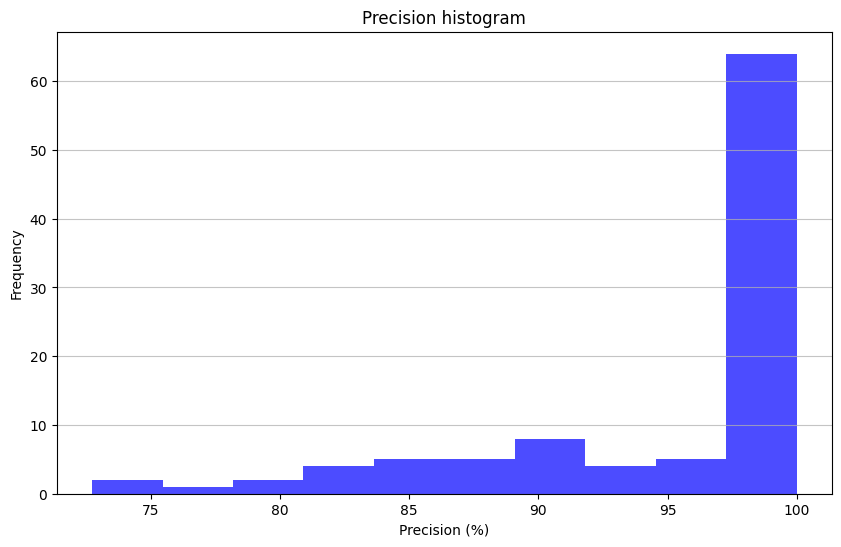

In [58]:
import matplotlib.pyplot as plt
df = pd.read_csv('./data/metrics/second_step/big_llama3_1.csv')

precision = df['precision']

plt.figure(figsize=(10, 6))
plt.hist(precision, bins=10, color='blue', alpha=0.7)
plt.title('Precision histogram')
plt.xlabel('Precision (%)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

In [50]:
len({'Madre': 'FAMILIARES_SUJETO_ASISTENCIA', '5/2026': 'FECHAS', 'C. La Salud': 'CENTRO_SALUD', '10': 'FECHAS', '13/12/26': 'FECHAS', '08/11': 'FECHAS', '6/2027': 'FECHAS', '09/10/27': 'FECHAS', '82/1/2027': 'FECHAS', '2/05/28': 'FECHAS', '07/12/27': 'FECHAS', '22/09/27': 'FECHAS', '13/10/28': 'FECHAS', '20/03/29': 'FECHAS', 'abr': 'FECHAS', 'jul de 2027': 'FECHAS', '15/08': 'FECHAS', '6/7/29': 'FECHAS', '13/11/28': 'FECHAS', '31/12/2028': 'FECHAS', '31/01/29': 'FECHAS', 'juny': 'FECHAS', 'Desembre': 'FECHAS'}
)

23

In [51]:
len({'Madre': 'FAMILIARES_SUJETO_ASISTENCIA', '5/2026': 'FECHAS', 'C. La Salud': 'HOSPITAL', '7/2026': 'FECHAS', '10': 'FECHAS', '13/12/26': 'FECHAS', '08/11': 'FECHAS', '6/2027': 'FECHAS', '09/10/27': 'FECHAS', '82/1/2027': 'FECHAS', '2/05/28': 'FECHAS', '07/12/27': 'FECHAS', '22/09/27': 'FECHAS', '13/10/28': 'FECHAS', '20/03/29': 'FECHAS', 'abr': 'FECHAS', 'jul de 2027': 'FECHAS', '15/08': 'FECHAS', '6/7/29': 'FECHAS', '13/11/28': 'FECHAS', '31/12/2028': 'FECHAS', '31/01/29': 'FECHAS', 'juny': 'FECHAS', 'Desembre': 'FECHAS'}
)

24